In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [2]:
from pyspark.sql.functions import col, when, count, round, year, month
from utils.read import read_csv_files

In [3]:
# Define the path variable
CLEANED_DATA_PATH = "/spark-data/capstone_crm/data/cleaned/"

# Customer Interaction effectiveness Analysis

In [4]:
try:
    logging.info("reading csv files")    
    # read customers data
    customers_df = read_csv_files(f"{CLEANED_DATA_PATH}customers.csv")
    # read transactions data
    interactions_df = read_csv_files(f"{CLEANED_DATA_PATH}interactions.csv")
except Exception as e:
    logging.error("Error in loading files :{e}", exc_info=True) 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/09 06:54:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/09 06:54:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/09 06:54:32 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/09 06:54:32 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/09/09 06:54:32 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/09/09 06:54:32 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


###  resolution rates for each interaction type

+----------------+------------------+---------------+---------------+
|Interaction_Type|Total_Interactions|Resolved_Issues|Resolution_Rate|
+----------------+------------------+---------------+---------------+
|              NA|                67|             27|           40.3|
|            Chat|               260|            130|           50.0|
|           Phone|               235|            134|          57.02|
|           Email|               244|            117|          47.95|
+----------------+------------------+---------------+---------------+



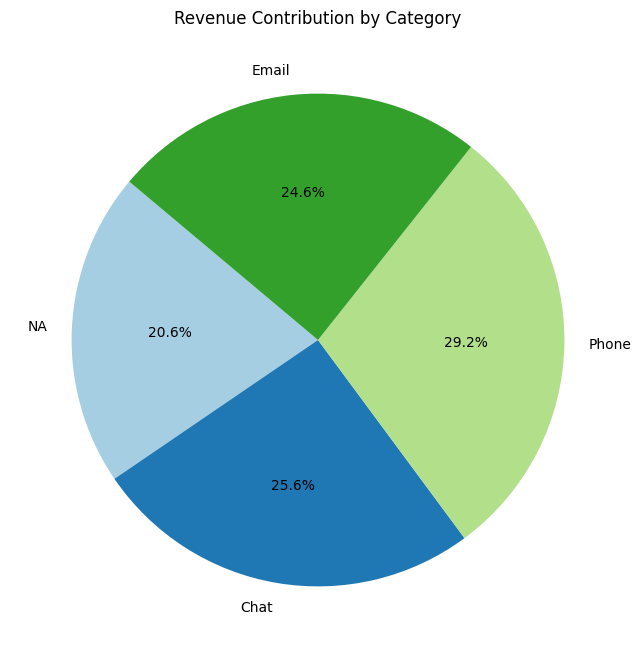

In [5]:
try: 
    logging.info("Resolution Rate For each Interaction Type")   
    # Calculate resolution rates for each interaction type
    resolution_rates_df = interactions_df.groupBy("Interaction_Type").agg(
        count("Issue_Resolved").alias("Total_Interactions"),
        count(when(col("Issue_Resolved") == "Yes", True)).alias("Resolved_Issues")
    ).withColumn(
        "Resolution_Rate", round(col("Resolved_Issues") / col("Total_Interactions") * 100, 2)
    )

    resolution_rates_df.show()
    
    # Convert to Pandas DataFrame for plotting
    resolution_rates_pd = resolution_rates_df.toPandas()

    # Plot
    
    plt.figure(figsize=(8, 8))
    plt.pie(resolution_rates_pd['Resolution_Rate'], labels=resolution_rates_pd['Interaction_Type'],
            autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title('Revenue Contribution by Category')
    plt.show()
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

In [6]:
try:    
    # Join customers with interactions to analyze preferences
    customer_interaction_df = interactions_df.join(customers_df, "Customer_ID")
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Calculate preference for each interaction type by country

+--------------------+----------------+-----------------+
|             Country|Interaction_Type|Interaction_Count|
+--------------------+----------------+-----------------+
|                Iran|            Chat|               13|
|             Reunion|           Phone|                6|
| Trinidad and Tobago|            Chat|                6|
|             Reunion|            Chat|                5|
|Bosnia and Herzeg...|           Phone|                5|
|            Bulgaria|           Email|                5|
|               Macao|            Chat|                5|
|             Austria|           Email|                5|
|              Brazil|           Email|                5|
|Heard Island and ...|           Phone|                5|
+--------------------+----------------+-----------------+



<Figure size 1200x800 with 0 Axes>

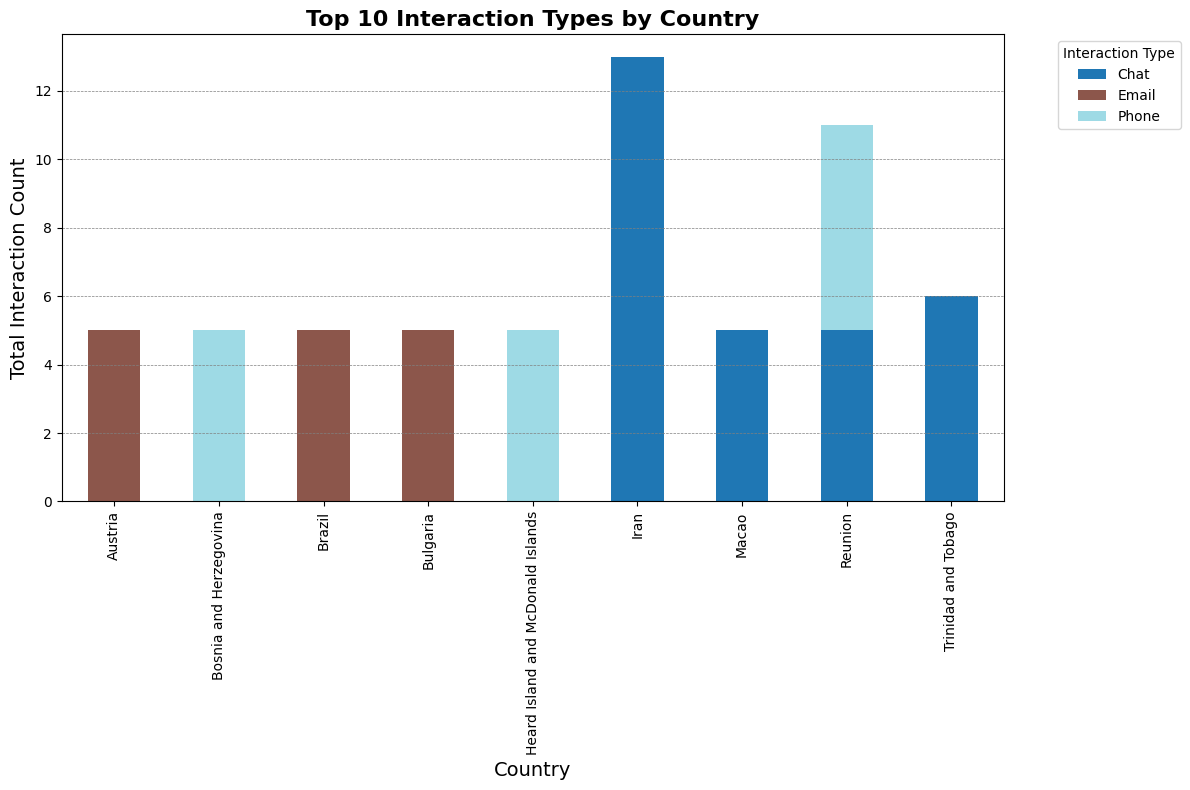

In [25]:
try:
    logging.info("Top 10 reference for each interaction type by country")
    # Calculate preference for each interaction type by country
    country_preference_interaction_type_df = customer_interaction_df.groupBy("Country", "Interaction_Type").agg(
        count("*").alias("Interaction_Count")
    ).orderBy("Interaction_Count", ascending=False)

    country_preference_interaction_type_df = country_preference_interaction_type_df.orderBy(col("Interaction_Count").desc()).limit(10)
    country_preference_interaction_type_df.show()
    
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    top_10_pd = country_preference_interaction_type_df.toPandas()
    
    # Pivot the data for stacked bar chart
    pivot_df = top_10_pd.pivot_table(
        index='Country', 
        columns='Interaction_Type', 
        values='Interaction_Count', 
        fill_value=0
    )
    
    # Plot
    plt.figure(figsize=(12, 8))

    # Create stacked bar chart
    pivot_df.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 8))

    plt.ylabel('Total Interaction Count', fontsize=14)
    plt.xlabel('Country', fontsize=14)
    plt.title('Top 10 Interaction Types by Country', fontsize=16, fontweight='bold')
    plt.legend(title='Interaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y', color='gray')

    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

    
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Calculate countries with highest Interaction count

+-------------------+-----------------------+
|            Country|Total_Interaction_Count|
+-------------------+-----------------------+
|               Iran|                     21|
|            Reunion|                     13|
|              Aruba|                     13|
|Trinidad and Tobago|                     13|
|              Macao|                     12|
|           Bulgaria|                     12|
|  Equatorial Guinea|                     11|
|              Nepal|                     11|
|            Liberia|                     10|
|          Australia|                     10|
+-------------------+-----------------------+



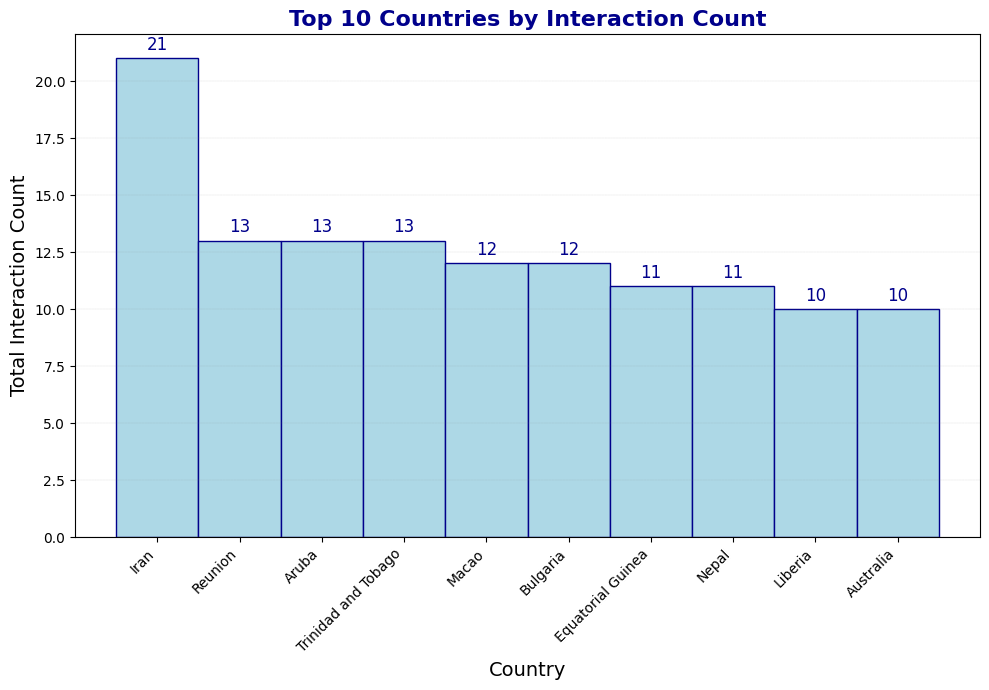

In [23]:
try:
    logging.info("top 10 countries with highest interaction count")    
    # Calculate countries with interaction count
    country_preference_df = customer_interaction_df.groupBy("Country").agg(
        count("*").alias("Total_Interaction_Count")
    ).orderBy("Total_Interaction_Count", ascending=False)
    country_preference_df = country_preference_df.limit(10)
    country_preference_df.show()
    
    # Collect the data from the PySpark DataFrame
    top_10_data = country_preference_df.select("Country", "Total_Interaction_Count").collect()

    # Extract data into lists
    countries = [row["Country"] for row in top_10_data]
    interaction_counts = [row["Total_Interaction_Count"] for row in top_10_data]

    # Plot the data using Matplotlib
    plt.figure(figsize=(10, 7))

    # Create the vertical bar chart
    bars = plt.bar(countries, interaction_counts, color='lightblue', edgecolor='darkblue',width=1.0)

    # Beautify the plot
    plt.ylabel('Total Interaction Count', fontsize=14)
    plt.xlabel('Country', fontsize=14)
    plt.title('Top 10 Countries by Interaction Count', fontsize=16, fontweight='bold', color='darkblue')
    plt.grid(True, which='both', linestyle='--', linewidth=0.1, axis='y', color='gray')

    # Add interaction count at the top of each bar
    for bar, interaction_count in zip(bars, interaction_counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.2,
            f'{int(interaction_count)}',
            ha='center',
            va='bottom',
            fontsize=12,
            color='darkblue'
        )

    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

### Calculate resolution rates and issue Resolved by country

In [9]:
try:
    logging.info("Countries where resolution rate is low")    
    # Calculate resolution rates by country
    country_resolution_df = customer_interaction_df.groupBy("Country").agg(
        count("Issue_Resolved").alias("Total_Interactions"),
        count(when(col("Issue_Resolved") == "Yes", True)).alias("Resolved_Issues")
    ).withColumn(
        "Resolution_Rate", round(col("Resolved_Issues") / col("Total_Interactions") * 100, 2)
    )

    country_resolution_df = country_resolution_df.orderBy(col("Resolution_Rate")).limit(10)
    country_resolution_df.show()
    
    
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True) 
    


+--------------------+------------------+---------------+---------------+
|             Country|Total_Interactions|Resolved_Issues|Resolution_Rate|
+--------------------+------------------+---------------+---------------+
|             Albania|                 2|              0|            0.0|
|    French Polynesia|                 2|              0|            0.0|
|             Bahamas|                 6|              0|            0.0|
|            Paraguay|                 1|              0|            0.0|
|              Turkey|                 2|              0|            0.0|
|Saint Kitts and N...|                 1|              0|            0.0|
|                Iraq|                 5|              0|            0.0|
|             Morocco|                 3|              0|            0.0|
|Northern Mariana ...|                 2|              0|            0.0|
|Turks and Caicos ...|                 1|              0|            0.0|
+--------------------+----------------

### calculate the issue with respect to particular customer and interaction type

In [10]:
try:
    logging.info("calculate Top 10 customers with interaction type who raised most interaction")
    #calculate the issue with respect to particular customer and interaction type
    customer_interaction_preference = customer_interaction_df.groupBy("Interaction_Type","Name").agg(
        count("*").alias("issue_raised")
    ).orderBy("issue_raised",ascending = False)

    customer_interaction_preference=customer_interaction_preference.select("Name","Interaction_Type","issue_raised").orderBy(col("issue_raised").desc()).limit(10)
    customer_interaction_preference.show()
    
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     

+--------------------+----------------+------------+
|                Name|Interaction_Type|issue_raised|
+--------------------+----------------+------------+
|    Tiffany Franklin|            Chat|           8|
|       Stephen Price|           Phone|           6|
|Christopher Casta...|            Chat|           4|
|    Tiffany Franklin|           Phone|           4|
|Christopher Casta...|           Phone|           4|
|       Stephen Price|            Chat|           4|
|      Laura Anderson|            Chat|           4|
|           Lori Rose|           Email|           4|
|        Laura Dillon|           Email|           3|
|      Kirsten Osborn|           Email|           3|
+--------------------+----------------+------------+



### Calculate resolution rates by year and month

+----+-----+----------------+------------------+---------------+---------------+
|Year|Month|Interaction_Type|Total_Interactions|Resolved_Issues|Resolution_Rate|
+----+-----+----------------+------------------+---------------+---------------+
|2024|    1|           Phone|                21|             11|          52.38|
|2024|    1|            Chat|                37|             20|          54.05|
|2024|    1|           Email|                38|             22|          57.89|
|2024|    1|              NA|                 7|              4|          57.14|
|2024|    2|           Email|                31|             21|          67.74|
|2024|    2|            Chat|                36|             18|           50.0|
|2024|    2|           Phone|                34|             25|          73.53|
|2024|    2|              NA|                 7|              3|          42.86|
|2024|    3|           Email|                26|             13|           50.0|
|2024|    3|              NA

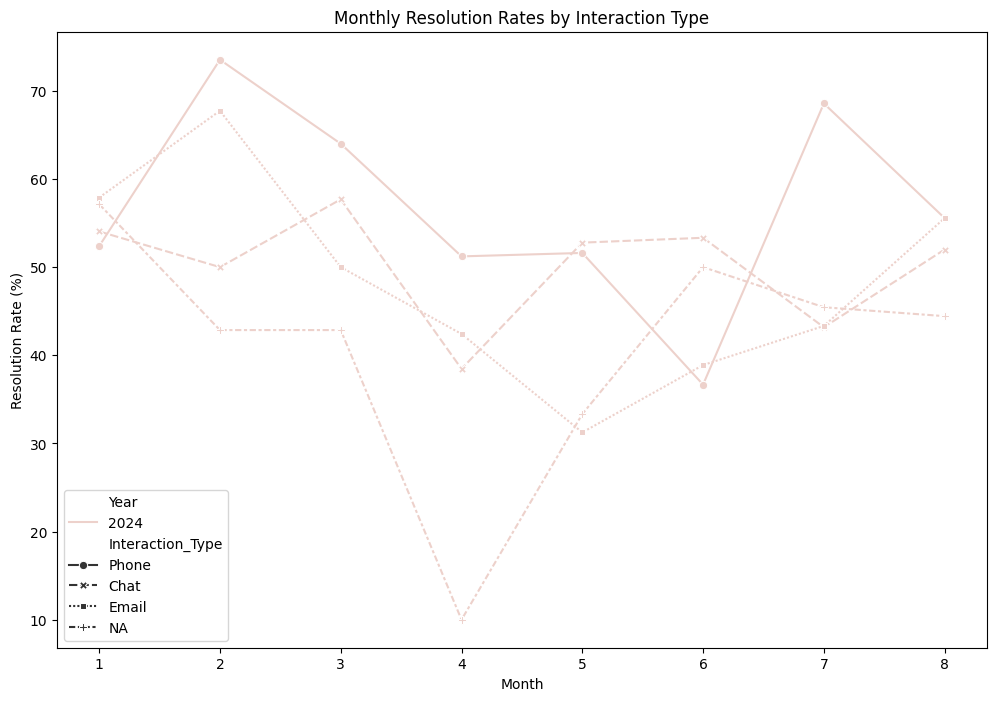

In [11]:
try:
    logging.info("Calculate resolution rates by year and month")    
    # Extract year and month from interaction date
    interactions_df = interactions_df.withColumn("Year", year("Interaction_Date"))
    interactions_df = interactions_df.withColumn("Month", month("Interaction_Date"))

    # Calculate resolution rates by year and month
    monthly_resolution_df = interactions_df.groupBy("Year", "Month", "Interaction_Type").agg(
        count("Issue_Resolved").alias("Total_Interactions"),
        count(when(col("Issue_Resolved") == "Yes", True)).alias("Resolved_Issues")
    ).withColumn(
        "Resolution_Rate", round(col("Resolved_Issues") / col("Total_Interactions") * 100, 2)
    ).orderBy("Year", "Month")

    monthly_resolution_df.show()
    
    # Convert to Pandas DataFrame for plotting
    monthly_resolution_pd = monthly_resolution_df.toPandas()

    # Plot using Matplotlib
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=monthly_resolution_pd, x='Month', y='Resolution_Rate', hue='Year', style='Interaction_Type', markers=True)
    plt.xlabel('Month')
    plt.ylabel('Resolution Rate (%)')
    plt.title('Monthly Resolution Rates by Interaction Type')
    plt.show()
    
except Exception as e:
    logging.error("invalid operation performed :{e}", exc_info=True)     